In [138]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [141]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import xml.etree.ElementTree as ET

#class to handle loading images and corresponding annotations
class SignatureDataset(torch.utils.data.Dataset):
    #contructor to initialize the dataset
    def __init__(self, root, transforms):
        self.root = root #sets root to the root directory
        self.transforms = transforms #any transformations to apply to the images
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images")))) #loads the image files
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations")))) #loads the xml, annotation files

    #function to get specific item from the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx]) #construct image path
        img = read_image(img_path) #load img from files and returned as a PyTorch tensor

        annotation_path = os.path.join(self.root, "annotations", self.annotations[idx]) #construct annotation path
        boxes, labels = self.parse_annotation(annotation_path) #contains bounding box coordinates and respective labels
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = { #dicationary containing the necessary data for training
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img)),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    #function to read XML files to extract bounding boxes and their labels
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path) #use the Element Tree library to read the XML file
        root = tree.getroot() #start fromt the root of the XML tree(aka the start)

        boxes = [] #store array of, possibly multiple, bounding box coordinates
        labels = []

        for obj in root.findall('object'): #loop over all the <objects> within the particular XML
            name = obj.find('name').text
            if name == "signature": #if we are within a signature, we know the bounding box cordinates will follow
                bndbox = obj.find('bndbox') #find the bndbox within the object
                #find and store the integer value of the cordinates
                xmin = int(bndbox.find('xmin').text)
                xmax = int(bndbox.find('xmax').text)
                ymin = int(bndbox.find('ymin').text)
                ymax = int(bndbox.find('ymax').text)

                boxes.append([xmin, ymin, xmax, ymax]) #store a array of arrays of cordinates
                labels.append(1) #store one to indicate a signature

        boxes = torch.tensor(boxes, dtype=torch.float32) # convert bounding boxes into PyTorch tensor
        labels = torch.tensor(labels, dtype=torch.int64) #convert labels into PyTorch tensor

        return boxes, labels

    #function to return the total num of images in the dataset
    def __len__(self):
        return len(self.imgs)



In [142]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#returns the fast_rcnn model with correct number of classes
#NOTE: this is where we can adjust hyperparams or change the model we are using
def get_model_faster_rcnn(num_classes):
    #load a pre-trained Faster R-CNN model with a ResNet-50 backbone and FPN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    #retrieve the number of input features for the classification layer of the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    #replace the box predictor with a new one that matches the number of classes in the dataset
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [143]:
from torchvision.transforms import v2 as T

#applies a series of transformations to the images
#takes param of train to indicate whether we are training or not
def get_transform(train):
    transforms = []#holds transformations
    if train:#add random horizontal flip to the list to help model ignore tilts
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))#converts image to floating point tensor
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [144]:
from engine import train_one_epoch, evaluate
import utils
import torch

#determine theh device to run the model on
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#define the number of classes, 1 for signature and 1 for the background
num_classes = 2

#load the training dataset with transformation
dataset = SignatureDataset('/content/drive/MyDrive/signature_data_ai_challenge/signature_data', get_transform(train=True))
#load the test dataset with transformations
dataset_test = SignatureDataset('/content/drive/MyDrive/signature_data_ai_challenge/signature_data', get_transform(train=False))

total_size = len(dataset)
indices = list(range(total_size))

print()
print("Total Dataset Size: ", len(dataset))

dataset = torch.utils.data.Subset(dataset, indices[:350])
print("Training Dataset Size: ", len(dataset))

dataset_test = torch.utils.data.Subset(dataset_test, indices[:-250])
print("Testing Dataset Size: ", len(dataset_test))

#create a data loader for the training dataset
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2, #number of samples per gradiant update
    shuffle=True, #shuffle the dataset on every epoch
    collate_fn=utils.collate_fn #custom collate function to handle batches
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2, #number of samples per gradiant update
    shuffle=False, #don't shuffle
    collate_fn=utils.collate_fn #cistom collate function
)

model = get_model_faster_rcnn(num_classes) #get model
model.to(device) #move model to the specified device

#create a parameter list for optimizer
params = [p for p in model.parameters() if p.requires_grad]

#Very Important for accurate model
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

#momentum adds a fraction of previous update to current update to accelerate SGD and dampen occilations
#weight_decay penalizes large weights to reduce overfitting

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)

num_epochs = 5

for epoch in range(num_epochs):

    print(f'Starting Epoch {epoch}/{num_epochs-1}')

    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)


#we need to create an evaluation function

torch.save(model.state_dict(), 'trained_model.pth')

print("Done!")



Total Dataset Size:  2059
Training Dataset Size:  350
Testing Dataset Size:  1809
Starting Epoch 0/4
Epoch: [0]  [  0/175]  eta: 0:06:59  lr: 0.000034  loss: 0.8557 (0.8557)  loss_classifier: 0.6513 (0.6513)  loss_box_reg: 0.0253 (0.0253)  loss_objectness: 0.1687 (0.1687)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 2.3953  data: 1.8408  max mem: 4441
Epoch: [0]  [ 10/175]  eta: 0:06:30  lr: 0.000321  loss: 0.8557 (0.7181)  loss_classifier: 0.3768 (0.3755)  loss_box_reg: 0.0416 (0.0424)  loss_objectness: 0.2430 (0.2855)  loss_rpn_box_reg: 0.0152 (0.0147)  time: 2.3668  data: 1.8512  max mem: 4441
Epoch: [0]  [ 20/175]  eta: 0:04:17  lr: 0.000608  loss: 0.3997 (0.5713)  loss_classifier: 0.1546 (0.2608)  loss_box_reg: 0.0792 (0.1025)  loss_objectness: 0.0979 (0.1869)  loss_rpn_box_reg: 0.0177 (0.0211)  time: 1.6219  data: 1.1086  max mem: 4441
Epoch: [0]  [ 30/175]  eta: 0:03:22  lr: 0.000895  loss: 0.3087 (0.4806)  loss_classifier: 0.1131 (0.2081)  loss_box_reg: 0.1450 (0.1082)  loss_obje

Selected Image: chicago_41.pdf_4.jpg


<ipython-input-156-2d20830e2b00>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model.pth'))


Confidence Scores: [0.9966432  0.97988427 0.9644478  0.92405975 0.413485   0.40197086
 0.25266126 0.05065572]


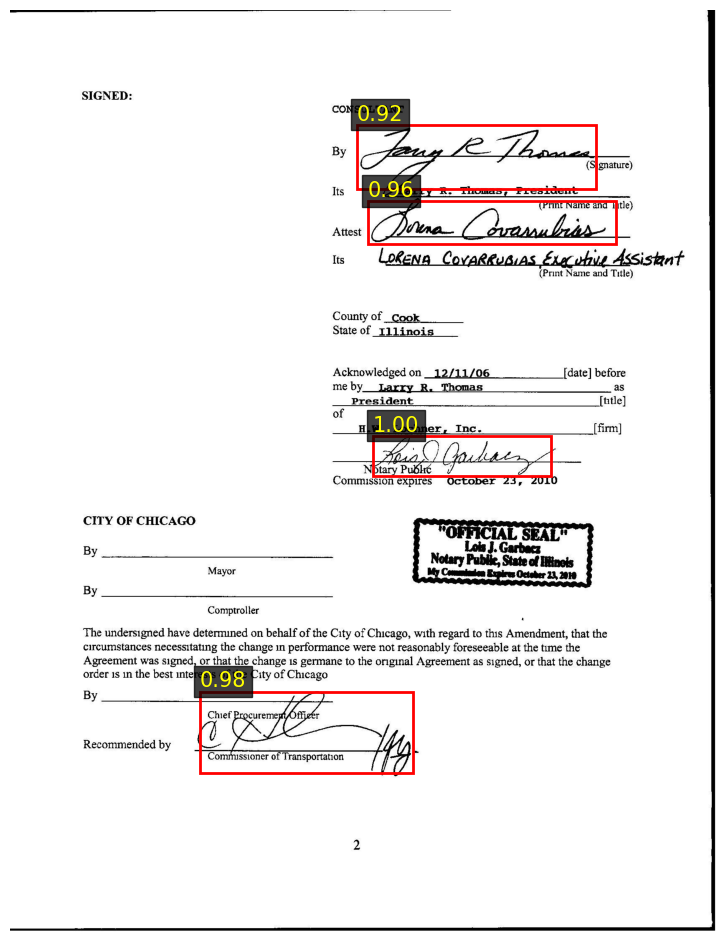

In [156]:
import os
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import torch

#function to load and transform an image
def load_image(image_path):
    img = Image.open(image_path) #open image

    #define a transformtion to convert the image to a tensor
    transform = T.Compose([
        T.ToTensor(),
    ])

    img = transform(img) #apply transformation

    return img

#function to display the image with bounding boxes
def show_image_with_boxes(image, boxes, scores):
    img = image.permute(1, 2, 0).cpu().numpy() #permute the image dimensions to (height, width, channels) for display

    plt.figure(figsize=(12, 12))
    plt.imshow(img)

    #loop through each bouning box and daw it on the image
    for i, box in enumerate(boxes):
        plt.gca().add_patch(plt.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            fill=False, edgecolor='red', linewidth=2
        ))
        #display the confidence score next to the bounding box
        plt.text(box[0], box[1] - 10, f"{scores[i]:.2f}", color='yellow', fontsize=15,
                 bbox=dict(facecolor='black', alpha=.75))

    plt.axis('off')
    plt.show()

image_folder = '/content/drive/MyDrive/signature_data_ai_challenge/signature_data/images'
#get list of image files in specified folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg'))]


image_filename = random.choice(image_files) #choose random image from folder
image_path = os.path.join(image_folder, image_filename) #make full image path

print(f"Selected Image: {image_filename}")

#load the trained model
model.load_state_dict(torch.load('trained_model.pth'))
model.to(device)
model.eval()

image = load_image(image_path)
image = image.to(device) #move image to specified location
image = image.unsqueeze(0)  # add a batch dimension


with torch.no_grad():  #sisable gradient tracking
    predictions = model(image)

#extract details from predictions
boxes = predictions[0]['boxes'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()

print("Confidence Scores:", scores)


confidence_threshold = 0.75 #define confidence threshold
#only use scores that meet the threshold
filtered_boxes = boxes[scores >= confidence_threshold]
filtered_scores = scores[scores >= confidence_threshold]

if len(filtered_boxes) == 0:
    print("No bounding boxes above the confidence threshold!!!!")
else:
    show_image_with_boxes(image.squeeze(0), filtered_boxes, filtered_scores)
